# Examples for EPTools
@copyright by Runduo Liang (Aujust)

## Crossmatch

In [1]:
import EPTools
from astropy.cosmology import Planck18
from astropy.coordinates import SkyCoord
from EPTools.utils import *
import numpy as np
import matplotlib.pyplot as plt

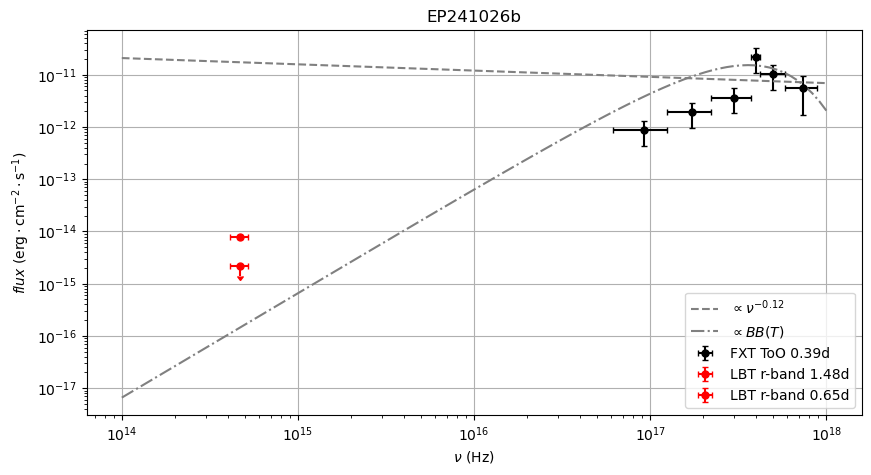

In [13]:
'calculate band flux'
'Lets plot SED of EP241026b'
'WXT observations at 2024-10-26 18:11:15'
'FXT 1st ToO started at 2024-10-27 03:36:23'
'LBT observations 1.48d post trigger, r=21.6'
from astropy.time import Time

import EPTools.model
dt_FXT = Time('2024-10-27T03:36:23',format='isot', scale='utc').mjd - Time('2024-10-26T18:11:15',format='isot', scale='utc').mjd
#Load FXT ToO data
fxt_sed = np.loadtxt('/Users/liangrunduo/EP/EP-TA-data/EP241026b/ep06800000178_FXTA_0301_s1/FXT_SED_1.txt',skiprows=3)
energy, energy_err, flux_kev,flux_kev_err = fxt_sed[:,0], fxt_sed[:,1], fxt_sed[:,2], fxt_sed[:,3]
x_nus = keV2Hz(energy)
x_nus_err = keV2Hz(energy+energy_err) - x_nus
x_flux = flux_kev * keV2erg(energy)
x_flux_err = flux_kev_err * keV2erg(energy)

LBT_wave, fwhm = EPTools.utils.band_wavelength['R']
LBT_nu = lam2Hz(LBT_wave)
LBT_nu_err = lam2Hz(LBT_wave-0.5*fwhm) - LBT_nu
LBT_flux = mag2flx(21.6,LBT_wave,fwhm)
mag_err = 0.2
LBT_flux_err = mag2flx(21.5,LBT_wave,fwhm) - mag2flx(21.6,LBT_wave,fwhm)
save_txt = np.array([[Hz2keV(lam2Hz(LBT_wave+0.5*fwhm)),Hz2keV(lam2Hz(LBT_wave-0.5*fwhm)),LBT_flux,LBT_flux_err]])
np.savetxt('/Users/liangrunduo/EP/EP-TA-data/EP241026b/LBT_2.txt',save_txt,delimiter=' ')
LBT_uplim = mag2flx(23,LBT_wave,fwhm)

'Plot data'
fig, ax = plt.subplots(figsize=(10,5),dpi=100)
ax.errorbar(x=x_nus,y=x_flux,xerr=x_nus_err,yerr=x_flux_err,capsize=2,fmt='o',markersize=5,color='k',label='FXT ToO {:.2f}d'.format(dt_FXT))
ax.errorbar(x=LBT_nu,y=LBT_flux,xerr=LBT_nu_err,yerr=LBT_flux_err,capsize=2,fmt='o',markersize=5,color='r',label='LBT r-band 1.48d')
ax.errorbar(x=LBT_nu,y=LBT_uplim,xerr=LBT_nu_err,yerr=LBT_flux_err,capsize=2,fmt='o',markersize=5,color='r',uplims=True,label='LBT r-band {:.2f}d'.format(15.6/24))


model_bb = EPTools.model.BlackBody()
T = keV2T(0.528383)   # from XSPEC

mo_nus = np.logspace(14,18,100)
y_bb = 3.5e-16*model_bb.calc_spectra(T,mo_nus)
y = 1e-9*mo_nus**(-0.12)
ax.plot(mo_nus,y,ls='--',color='gray',label=r'$\propto \nu^{-0.12}$')
ax.plot(mo_nus,y_bb,ls='-.',color='grey',label=r'$\propto BB(T)$')

ax.set_xscale('log')
ax.set_yscale('log')
#ax.invert_xaxis()
ax.grid()
ax.set_xlabel(r'$\nu$ (Hz)')
ax.set_ylabel(r'$flux\ (\mathrm{erg}\cdot \mathrm{cm}^{-2} \cdot \mathrm{s}^{-1})$')
ax.legend()
ax.set_title('EP241026b')
plt.savefig('/Users/liangrunduo/EP/EP-TA-data/EP241026b/prelimiary_FXT_LBT.pdf',dpi=300)

In [11]:
import sncosmo
h = c.h
e = h*LBT_nu*u.Hz
e = e.cgs.value
print(e)
ab = sncosmo.get_magsystem('ab')
print(ab.band_mag_to_flux(21.6,'bessellr')*e)
print(LBT_flux)
print(LBT_flux_err)

3.090782413488296e-12
8.764868562487556e-15
7.916441989068866e-15
7.637640429775859e-16


In [8]:
print(lam2keV(LBT_wave))
print(Hz2keV(LBT_nu)-Hz2keV(lam2Hz(LBT_wave+0.5*fwhm)))

0.0019291136413002667
0.0001769353806110618


In [23]:
crossmatch = EPTools.Crossmatch()

pos = '56.4035 41.0306'

#data = crossmatch.xmm_slew_archive(pos)
data_ztf = crossmatch.ztf_lc(pos,band='r')
print(data_ztf)

Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.17 (26 JAN 2024)
Please upgrade your client if not up to date.



TimeoutError: The read operation timed out